In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
import urllib3
import zipfile
import shutil
import os
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [3]:
# 상대경로로 코드를 짜려다보니 다운받아서 압축해재하는데만 이만큼의 코드가 필요함

http = urllib3.PoolManager()
url = 'http://www.manythings.org/anki/fra-eng.zip'
filename = 'fra-eng.zip'
path = os.getcwd()
zipfilename = os.path.join(path, filename) # 이런식으로 할수도 있구나

with http.request('GET', url, preload_content = False) as r, open(zipfilename, 'wb') as out_file:
    shutil.copyfileobj(r, out_file)

# r = http.request('GET', url, preload_content = False)

# out_file = open(zipfilename, 'wb')
# shutil.copyfileobj(r, out_file)
# 그냥 직접 다운받아서 open 하면 안돼? -> 안돼 상대경로로 잡으려고 일부러 이렇게 한거야

with zipfile.ZipFile(zipfilename, 'r') as zip_ref:
    zip_ref.extractall(path)
# zip_ref = zipfile.ZipFile(zipfilename, 'r')
# zip_ref.extractall(path)

In [4]:
lines = pd.read_csv('fra.txt', names = ['src', 'tar', 'lic'], sep = '\t')
del lines['lic']
len(lines)

189986

In [5]:
lines = lines.loc[:, 'src':'tar']
# loc : label을 이용하여 행에 "접근"&"인덱싱"하는 메서드
lines = lines[0:60000]
lines.sample(10) #상위 10개가 아니라 랜덤으로 10개를 말함

,src,tar
27526,Can I do that here?,Est-ce que je peux faire ça ici ?
59932,Are you blackmailing me?,Exercez-vous un chantage à mon égard ?
22242,Do you want a car?,Tu veux une voiture ?
5357,It's special.,C'est spécial.
56048,I've got some problems.,J'ai des problèmes.
29995,It was quite funny.,Ce fut assez amusant.
56983,She sang as she walked.,Elle chantait en marchant.
38766,Will you eat dinner?,Déjeuneras-tu ?
1035,I love it.,J'adore ça !
32847,You should turn in.,Tu devrais te rendre.


In [6]:
lines.tar = lines.tar.apply(lambda x: '\t ' + x + ' \n')
lines.sample(10)

,src,tar
18669,I'll beat you up!,\t Je vais te cogner ! \n
57369,The boy is very honest.,\t C'est un garçon très honnête. \n
54895,I hope we can fix that.,\t J'espère que nous pouvons arranger ça. \n
21679,You're not alone.,\t Tu n'es pas seule. \n
33757,Don't take the bait.,\t Ne mords pas à l'appât. \n
20317,Tom glanced away.,\t Tom a détourné le regard. \n
18650,I worry too much.,\t Je me fais trop de souci. \n
20760,Watch yourselves!,\t Faites attention à vous ! \n
21588,You're all alone.,\t Vous êtes toutes seules. \n
8468,Tie your shoe.,\t Attache ton lacet de chaussure. \n


In [7]:
# 글자 집합 구축(토큰 단위가 단어가 아닌 글자이기 때문)

src_vocab = set() # set()은 집합 생성 함수 {3,4,5} 순서도 없고, 중복도 불가능한 바로 그 집합
for line in lines.src:
    for char in line:
        src_vocab.add(char)
        
tar_vocab = set()
for line in lines.tar:
    for char in line:
        tar_vocab.add(char)

In [8]:
src_vocab_size = len(src_vocab) + 1
tar_vocab_size = len(tar_vocab) + 1
print(src_vocab_size)
print(tar_vocab_size)

79
105


In [9]:
# 인덱스를 부여해서 일부만 출력하고 싶은데 집합 상태로는 순서가 없기때문에 일부만 못해 그래서!
src_vocab = sorted(list(src_vocab)) 
tar_vocab = sorted(list(tar_vocab))

In [10]:
print(src_vocab[45:75])
print(tar_vocab[45:75])

['W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
['T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w']


In [11]:
src_to_index = dict([(word, i+1) for i, word in enumerate(src_vocab)])
tar_to_index = dict([(word, i+1) for i, word in enumerate(tar_vocab)])
# 근데 왜 dict() 안에 [] 중괄호로 감쌌을까 중괄호 없으면 안되나?
print(src_to_index)
print(tar_to_index)

{' ': 1, '!': 2, '"': 3, '$': 4, '%': 5, '&': 6, "'": 7, ',': 8, '-': 9, '.': 10, '/': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, '9': 21, ':': 22, '?': 23, 'A': 24, 'B': 25, 'C': 26, 'D': 27, 'E': 28, 'F': 29, 'G': 30, 'H': 31, 'I': 32, 'J': 33, 'K': 34, 'L': 35, 'M': 36, 'N': 37, 'O': 38, 'P': 39, 'Q': 40, 'R': 41, 'S': 42, 'T': 43, 'U': 44, 'V': 45, 'W': 46, 'X': 47, 'Y': 48, 'Z': 49, 'a': 50, 'b': 51, 'c': 52, 'd': 53, 'e': 54, 'f': 55, 'g': 56, 'h': 57, 'i': 58, 'j': 59, 'k': 60, 'l': 61, 'm': 62, 'n': 63, 'o': 64, 'p': 65, 'q': 66, 'r': 67, 's': 68, 't': 69, 'u': 70, 'v': 71, 'w': 72, 'x': 73, 'y': 74, 'z': 75, 'é': 76, '’': 77, '€': 78}
{'\t': 1, '\n': 2, ' ': 3, '!': 4, '"': 5, '$': 6, '%': 7, '&': 8, "'": 9, '(': 10, ')': 11, ',': 12, '-': 13, '.': 14, '0': 15, '1': 16, '2': 17, '3': 18, '4': 19, '5': 20, '6': 21, '7': 22, '8': 23, '9': 24, ':': 25, '?': 26, 'A': 27, 'B': 28, 'C': 29, 'D': 30, 'E': 31, 'F': 32, 'G': 33, 'H': 34, 'I': 3

In [12]:
encoder_input = []
for line in lines.src:
    temp_X = []
    for w in line:
        temp_X.append(src_to_index[w]) #dict[key] = value
    encoder_input.append(temp_X)
print(encoder_input[:5])
#char마다 정수인코딩 완료

[[30, 64, 10], [30, 64, 10], [30, 64, 10], [31, 58, 10], [31, 58, 10]]


In [13]:
decoder_input = []
for line in lines.tar:
    temp_X = []
    for w in line:
        temp_X.append(tar_to_index[w])
    decoder_input.append(temp_X)
print(decoder_input[:5])

[[1, 3, 48, 53, 3, 4, 3, 2], [1, 3, 39, 53, 70, 55, 60, 57, 14, 3, 2], [1, 3, 28, 67, 73, 59, 57, 3, 4, 3, 2], [1, 3, 45, 53, 64, 73, 72, 3, 4, 3, 2], [1, 3, 45, 53, 64, 73, 72, 14, 3, 2]]


In [14]:
decoder_target = []
for line in lines.tar:
    t = 0
    temp_X = []
    for w in line:
        if t > 0:
            temp_X.append(tar_to_index[w])
        t = t + 1
    decoder_target.append(temp_X)
print(decoder_target[:5])
# 왜 이렇게 하는거야? 그냥 decoder_input에서 모든 리스트들마다 첫번째걸 삭제하면 되는거 아니야?
# 아 맞다 파이썬은 리스트 원소 삭제 기능이 없었지

[[3, 48, 53, 3, 4, 3, 2], [3, 39, 53, 70, 55, 60, 57, 14, 3, 2], [3, 28, 67, 73, 59, 57, 3, 4, 3, 2], [3, 45, 53, 64, 73, 72, 3, 4, 3, 2], [3, 45, 53, 64, 73, 72, 14, 3, 2]]


In [15]:
# 패딩 해보자
max_src_len = max([len(line) for line in lines.src])
max_tar_len = max([len(line) for line in lines.tar])
print(max_src_len)
print(max_tar_len)

24
76


In [16]:
encoder_input = pad_sequences(encoder_input, maxlen = max_src_len, padding='post')
# padding = 'pre' : 앞쪽에 패딩, 'post' : 뒷쪽에 패딩
decoder_input = pad_sequences(decoder_input, maxlen = max_tar_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_tar_len, padding='post')


In [17]:
# 원핫인코딩 : 단위가 char 이기 때문에 임베딩은 따로 필요 없음
encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)

In [18]:
# 교사 강요(teacher forcing)를 통한 seq2seq 기계 번역기 훈련
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model
import numpy as np

In [19]:
encoder_input[6] # 가로는 padding한 max_src_len 24일거고, 세로는 char갯수

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [20]:
import numpy as np

# 미묘하게 다름 input's' 임
encoder_inputs = Input(shape=(None, src_vocab_size))
encoder_lstm = LSTM(units=256, return_state = True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
# encoder_outputs : hidden state
# state_h : last hidden state
# state_c : last cell state
encoder_states = [state_h, state_c]
# 마지막 hiddenstate, cellstate 두개가 context임 둘다 디코더로 전달함


# 케라스 API  
  
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(3, input_dim=4, activation='softmax'))

이것처럼 Sequential() API는 단순히 층을 쌓는 것만으로 기본적인 모델을 만들수 있지만  
쌓는게 전부가 아닌 복잡한 신경망들은 Sequential API 만으로는 구현할수 없음  
더 복작한 신경망들은 Functional API의 Model을 이용해서 하나하나 정의내려줘야함  
  
https://wikidocs.net/38861  
위의 링크 반드시 시도해볼것

In [21]:
decoder_inputs = Input(shape=(None, tar_vocab_size))
decoder_lstm = LSTM(units=256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state = encoder_states)
# 디코더의 첫 상태를 인코더의 은닉 상태, 셀 상태로 함

decoder_softmax_layer = Dense(tar_vocab_size, activation = 'softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
# Model(input, output)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy")

In [22]:
model.fit(x=[encoder_input, decoder_input], y=decoder_target, batch_size = 64, epochs = 50, validation_split = 0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 248s 5ms/sample - loss: 0.7463 - val_loss: 0.6720
Epoch 2/50
48000/48000 [==============================] - 258s 5ms/sample - loss: 0.4624 - val_loss: 0.5443
Epoch 3/50
48000/48000 [==============================] - 276s 6ms/sample - loss: 0.3836 - val_loss: 0.4739
Epoch 4/50
48000/48000 [==============================] - 291s 6ms/sample - loss: 0.3402 - val_loss: 0.4333
Epoch 5/50
48000/48000 [==============================] - 292s 6ms/sample - loss: 0.3116 - val_loss: 0.4079
Epoch 6/50
48000/48000 [==============================] - 289s 6ms/sample - loss: 0.2910 - val_loss: 0.3924
Epoch 7/50
48000/48000 [==============================] - 287s 6ms/sample - loss: 0.2751 - val_loss: 0.3801
Epoch 8/50
48000/48000 [==============================] - 283s 6ms/sample - loss: 0.2621 - val_loss: 0.3715
Epoch 9/50
48000/48000 [==============================] - 278s 6ms/sample - loss: 0.25

In [23]:
from tensorflow.python.keras.models import load_model
model.save('seq2seq_fraeng2.h5')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 79)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 105)]  0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 344064      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  370688      input_2[0][0]                    
                                                                 lstm[0][1]                   

In [24]:
# # 모델 불러오기
# from tensorflow.python.keras.models import load_model
# model = load_model('seq2seq_fraeng2.h5')
# model.summary()

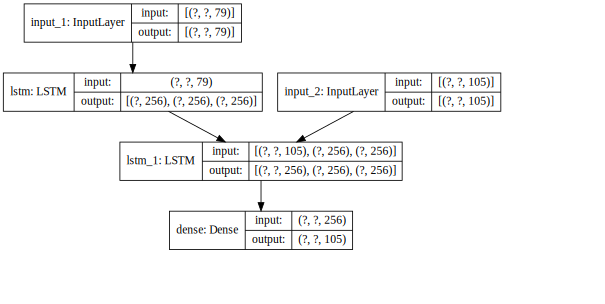

In [25]:
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True, dpi=60).create(prog='dot', format='svg'))

# seq2seq 기계 번역기 동작시키기  
  
seq2seq는 훈련과 test할때의 동작이 다름  
1. 번역하고자 하는 입력 문장이 인코더에 들어가서 은닉상태와 셀 상태를 얻음  
2. 상태와 <SOS>에 해당하는 '\t'를 디코더로 보냄  
3. 디코더가 <EOS>에 해당하는 '\n'이 나올때까지 다음 문자를 예측하는 행동을 반복

In [26]:
# encoder model
encoder_model = Model(inputs=encoder_inputs, outputs=encoder_states)
# 학습할때 썼던 inputs과 outputs을 테스트때도 사용함

In [27]:
# decoder model #훈련과정과 다른 부분이 decoder 부분이므로 encoder model과 달리 training 때 했던걸 재활용 불가함

decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
#위의 두개는 encoder_model의 encoder_states가 넘어갈거기 때문에 차원이 256인거
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state = decoder_states_inputs)
# decoder_inputs = Input(shape=(None, tar_vocab_size))
# 다음 단어를 예측하기 위해서 초기상태(initial_state)를 이전 시점의 상태로 사용
# 이는 뒤의 함수 decode_sequence()에서 구현

decoder_states = [state_h, state_c]

decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs,
                      outputs=[decoder_outputs] + decoder_states)
# [[a,b,c]] + [[d,e]] = [[a,b,c],[d,e]]


In [28]:
# a = [1,2,3,4]
# b = [1,2,3,4]
# c = a + b
# print(c)

# aa = [[1,2,3,4]]
# bb = [[1,2,3,4]]
# cc= aa + bb
# print(cc)

# dd = aa + a
# print(dd)

In [29]:
# index로부터 단어를 얻을 수 있음
index_to_src = dict((i, char) for char, i in src_to_index.items())
#src_to_index = dict([(word, i+1) for i, word in enumerate(src_vocab)])
# (a, 3)
index_to_tar = dict((i, char) for char, i in tar_to_index.items())

In [30]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)
    # inputs = encoder_inputs
    # encoder_inputs = Input(shape=(None, src_vocab_size))
    # outputs = encoder_states
    # encoder_states = [state_h, state_c]
    
    # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1, 1, tar_vocab_size))
    target_seq[0, 0, tar_to_index['\t']] = 1
    
    stop_condition = False
    decoded_sentence = ""
    
    #stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이전 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq]+states_value)
        
        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0,-1,:])
        # np.argmax 최대값의 index를 반환
        sampled_char = index_to_tar[sampled_token_index]
        
        #현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += sampled_char
        
        #<eos>에 도달하거나 최대 길이를 넘으면 중단
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_tar_len):
            stop_condition = True
            
        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1, tar_vocab_size))
        target_seq[0, 0, sampled_token_index] = 1
        
        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]
        
    return decoded_sentence     

In [31]:
# target_seq = np.zeros((1, 1, tar_vocab_size))
# target_seq[0, 0, tar_to_index['\t']] = 1
# print(target_seq)

In [32]:
for seq_index in [50, 100, 300, 1001]:
    input_seq = encoder_input[seq_index:seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.src[seq_index])
    print('정답 문장:', lines.tar[seq_index][1:len(lines.tar[seq_index])-1])
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1])
    

-----------------------------------
입력 문장: I see.
정답 문장:  Aha. 
번역기가 번역한 문장:  Je crois. 
-----------------------------------
입력 문장: Hug me.
정답 문장:  Serrez-moi dans vos bras ! 
번역기가 번역한 문장:  Serrez-moi dans votre connaissain. 
-----------------------------------
입력 문장: Hold it!
정답 문장:  Restez où vous êtes ! 
번역기가 번역한 문장:  Ne bouge pas. 
-----------------------------------
입력 문장: I crashed.
정답 문장:  Je me suis écrasée. 
번역기가 번역한 문장:  Je me suis amusé. 


In [33]:
print(lines.src[50])
encoder_input[50:51].shape
encoder_input[50:51]

I see.


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]], dtype=float32)